In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.patches import Patch
import seaborn as sns
import scipy.stats as stats
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu
from scipy.stats import sem
import scikit_posthocs as sp

sc._settings.ScanpyConfig(n_jobs=-1)

In [2]:
# Specify the path to your Helvetica Neue Regular font file
helvetica_neue_path = "/home/mstier/.local/share/fonts/HelveticaNeue-Regular.ttf"

# Create a FontProperties object using the font path
prop_neue = fm.FontProperties(fname=helvetica_neue_path)

# Get the font name from FontProperties
helvetica_neue_name = prop_neue.get_name()

# Define custom context for font sizes and line thickness using Seaborn
custom_context = {
    'font.size': 7,                    # General font size for the plot
    'axes.labelsize': 7,               # Font size for axis labels
    'axes.titlesize': 7,               # Font size for titles
    'legend.fontsize': 7,              # Font size for legend
    'axes.linewidth': 0.6,             # Line width for axes spines
    'grid.linewidth': 0.6,             # Line width for grid lines
    'lines.linewidth': 0.6,            # Line width for plot lines
    'lines.markersize': 3,             # Size of markers in scatter/line plots
    'patch.linewidth': 0.6,            # Line width for boxplot edges
    'xtick.major.size': 3,             # Length of major ticks on x-axis
    'ytick.major.size': 3,             # Length of major ticks on y-axis
    'xtick.labelsize': 7,              # Font size for x-tick labels
    'ytick.labelsize': 7,              # Font size for y-tick labels
    'legend.title_fontsize': 7,        # Font size for legend title
}

# Define custom style for aesthetic elements like background, grid, and spines using Seaborn
custom_style = {
    'axes.facecolor': 'white',         # Background color of the axes
    'axes.edgecolor': 'black',         # Color of the border around the plot
    'axes.grid': False,                # Disable gridlines
    'grid.color': '#EAEAEA',           # Color of grid lines
    'grid.linestyle': '--',            # Style of the grid lines (dashed)
    'xtick.color': 'black',            # Color of x-axis tick labels
    'ytick.color': 'black',            # Color of y-axis tick labels
    'ytick.left': True,
    'xtick.bottom': True,
    'xtick.direction': 'out',          # Direction of x-axis ticks
    'ytick.direction': 'out',          # Direction of y-axis ticks
    'axes.spines.left': True,          # Show the left spine (border)
    'axes.spines.bottom': True,        # Show the bottom spine (border)
    'axes.spines.right': False,        # Hide the right spine
    'axes.spines.top': False,          # Hide the top spine
}

# Use set_theme and pass rc with font settings
sns.set_theme(
    context=custom_context,
    style=custom_style,
    rc={
        'font.family': 'sans-serif',                   # Set family to sans-serif
        'font.sans-serif': [helvetica_neue_name],      # Specify Helvetica Neue as the sans-serif font
        'font.size': 7,                                # General font size for the plot
        'axes.labelsize': 7,                           # Font size for axis labels
        'axes.titlesize': 7,                           # Font size for titles
        'legend.fontsize': 7,                          # Font size for legend
        'xtick.labelsize': 7,                          # Font size for x-tick labels
        'ytick.labelsize': 7                           # Font size for y-tick labels
    }
)

plt.rcParams['svg.fonttype'] = 'none'

In [3]:
# Set the base output directory for all figures
output_dir = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure3/'


Naive - Kruskal-Wallis H-statistic: 10.10, p-value: 0.0064
Naive - Dunn's post-hoc test (Bonferroni-adjusted p-values):
           CI-NS    CI-Sep       NHC
CI-NS   1.000000  0.978539  0.102660
CI-Sep  0.978539  1.000000  0.004658
NHC     0.102660  0.004658  1.000000


Eff/EM - Kruskal-Wallis H-statistic: 6.69, p-value: 0.0353
Eff/EM - Dunn's post-hoc test (Bonferroni-adjusted p-values):
           CI-NS    CI-Sep       NHC
CI-NS   1.000000  0.755797  0.461408
CI-Sep  0.755797  1.000000  0.029483
NHC     0.461408  0.029483  1.000000


CM - Kruskal-Wallis H-statistic: 12.13, p-value: 0.0023
CM - Dunn's post-hoc test (Bonferroni-adjusted p-values):
           CI-NS    CI-Sep       NHC
CI-NS   1.000000  1.000000  0.023636
CI-Sep  1.000000  1.000000  0.002089
NHC     0.023636  0.002089  1.000000


Treg - Kruskal-Wallis H-statistic: 9.94, p-value: 0.0070
Treg - Dunn's post-hoc test (Bonferroni-adjusted p-values):
           CI-NS    CI-Sep       NHC
CI-NS   1.000000  0.451914  0.266864
CI-

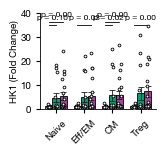

In [22]:
path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure3/2024-05-03_CD4T_HK1_mfi_POOLED.csv'
df = pd.read_csv(path)

# Define the groups, color scheme, and markers
group_order = ['NHC', 'CI-NS', 'CI-Sep']
group_palette = {'NHC': '#BBBBBB', 'CI-NS': '#009E73', 'CI-Sep': '#9F4A96'}

# Define the cell types of interest with readable labels for fold change
cell_types = {
    'CD4 Tnaive FC': 'Naive',
    'CD4 Teffem FC': 'Eff/EM',
    'CD4 Tcm FC': 'CM',
    'CD4 Treg FC': 'Treg'
}

# Filter the dataset for the cell types of interest and rename the FC columns
df = df.rename(columns={col: cell_types[col] for col in cell_types if col in df.columns})

# Reshape the DataFrame for plotting
df_long = df.melt(id_vars=['Group'], value_vars=list(cell_types.values()), 
                  var_name='cell_type', value_name='Fold Change')

# Calculate means and SEMs for error bars
means_sems = df_long.groupby(['Group', 'cell_type'])['Fold Change'].agg(['mean', 'sem']).reset_index()

# Set figure size
fig, ax = plt.subplots(figsize=(1.5, 1.25))

# Define bar positions
num_cell_types = len(cell_types)
bar_width = 0.25
x = np.arange(num_cell_types)

# Plot bars for each group, ordered by x-axis labels
for i, cell_type in enumerate(cell_types.values()):
    for j, group in enumerate(group_order):
        # Select the mean and SEM for the current group and cell type
        mean_val = means_sems[(means_sems['Group'] == group) & (means_sems['cell_type'] == cell_type)]['mean'].values[0]
        sem_val = means_sems[(means_sems['Group'] == group) & (means_sems['cell_type'] == cell_type)]['sem'].values[0]

        # Calculate the bar position
        bar_position = x[i] + j * bar_width - bar_width

        # Plot the bar
        ax.bar(
            bar_position, mean_val, yerr=sem_val, width=bar_width, 
            label=group if i == 0 else "", color=group_palette[group], 
            edgecolor='black', capsize=2, error_kw={'elinewidth': 0.6, 'capthick': 0.6}
        )

        # Overlay individual data points with jitter
        subset = df_long[(df_long['Group'] == group) & (df_long['cell_type'] == cell_type)]
        jitter = (np.random.rand(len(subset)) - 0.5) * 0.1  # Jitter for visualization

        # Adjust x-coordinates to match the corresponding bars
        x_coords = [bar_position + jitter_val for jitter_val in jitter]
        ax.scatter(
            x_coords, subset['Fold Change'], color='white', edgecolor='black', 
            s=4, linewidth=0.6, zorder=3
        )

# Add a solid horizontal line at y=0
ax.axhline(0, color='black', linewidth=0.6)

# Set x-ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(cell_types.values(), rotation=45, ha='center')

# Set y-axis limits and ticks
ax.set_ylim(0, 40)
ax.set_yticks(np.arange(0, 41, 10))
ax.set_ylabel('HK1 (Fold Change)', labelpad=1)

# Perform Kruskal-Wallis test and Dunn's post-hoc test for each cell type
for cell_type in cell_types.values():
    subsets = [df_long[(df_long['Group'] == group) & (df_long['cell_type'] == cell_type)]['Fold Change'] for group in group_order]
    kw_stat, kw_pval = kruskal(*subsets)
    print(f'\n{cell_type} - Kruskal-Wallis H-statistic: {kw_stat:.2f}, p-value: {kw_pval:.4f}')
    
    # Always perform Dunn's post-hoc test
    dunn_results = sp.posthoc_dunn(
        df_long[df_long['cell_type'] == cell_type], 
        val_col='Fold Change', group_col='Group', p_adjust='bonferroni'
    )
    
    # Display Dunn's test results in table format
    print(f"{cell_type} - Dunn's post-hoc test (Bonferroni-adjusted p-values):\n{dunn_results}\n")
    
    # Add comparison bars and p-values for significant results (K-W p < 0.05 and Dunn's p < 0.25)
    if kw_pval < 0.05:
        offset_increment = 1  # Adjust to prevent overlapping
        current_y_pos = 35  # Start position for comparison lines

        for i, group1 in enumerate(group_order):
            for j, group2 in enumerate(group_order):
                if i < j:  # Only consider each pair once
                    p_val = dunn_results.loc[group1, group2]
                    if p_val < 0.25:
                        # Calculate bar positions for comparison lines
                        x_start = x[list(cell_types.values()).index(cell_type)] + i * bar_width - bar_width
                        x_end = x[list(cell_types.values()).index(cell_type)] + j * bar_width - bar_width
                        y_pos = current_y_pos

                        # Add the comparison line
                        ax.plot([x_start, x_end], [y_pos, y_pos], color='black', linewidth=0.6)
                        
                        # Add p-value text above the bar
                        ax.text((x_start + x_end) / 2, y_pos + 2, f'p = {p_val:.2f}', 
                                ha='center', va='bottom', fontsize=6, color='black')

                        # Update current y-position for the next comparison line
                        current_y_pos += offset_increment

# Show the plot
plt.savefig('HK1_FC.svg')
plt.show()


Naive - Kruskal-Wallis H-statistic: 4.66, p-value: 0.0974
Naive - Dunn's post-hoc test (Bonferroni-adjusted p-values):
           CI-NS    CI-Sep       NHC
CI-NS   1.000000  0.092866  0.771827
CI-Sep  0.092866  1.000000  1.000000
NHC     0.771827  1.000000  1.000000


Eff/EM - Kruskal-Wallis H-statistic: 3.35, p-value: 0.1875
Eff/EM - Dunn's post-hoc test (Bonferroni-adjusted p-values):
           CI-NS    CI-Sep       NHC
CI-NS   1.000000  0.231665  1.000000
CI-Sep  0.231665  1.000000  0.771744
NHC     1.000000  0.771744  1.000000


CM - Kruskal-Wallis H-statistic: 3.20, p-value: 0.2015
CM - Dunn's post-hoc test (Bonferroni-adjusted p-values):
           CI-NS    CI-Sep       NHC
CI-NS   1.000000  0.253033  1.000000
CI-Sep  0.253033  1.000000  0.792276
NHC     1.000000  0.792276  1.000000


Treg - Kruskal-Wallis H-statistic: 5.67, p-value: 0.0588
Treg - Dunn's post-hoc test (Bonferroni-adjusted p-values):
           CI-NS    CI-Sep       NHC
CI-NS   1.000000  0.092646  1.000000
CI-Se

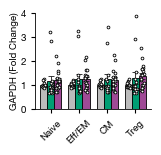

In [27]:
path = '/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure3/2024-05-03_CD4T_GAPDH_mfi_POOLED.csv'
df = pd.read_csv(path)

# Define the groups, color scheme, and markers
group_order = ['NHC', 'CI-NS', 'CI-Sep']
group_palette = {'NHC': '#BBBBBB', 'CI-NS': '#009E73', 'CI-Sep': '#9F4A96'}

# Define the cell types of interest with readable labels for fold change
cell_types = {
    'CD4 Tnaive FC': 'Naive',
    'CD4 Teffem FC': 'Eff/EM',
    'CD4 Tcm FC': 'CM',
    'CD4 Treg FC': 'Treg'
}

# Filter the dataset for the cell types of interest and rename the FC columns
df = df.rename(columns={col: cell_types[col] for col in cell_types if col in df.columns})

# Reshape the DataFrame for plotting
df_long = df.melt(id_vars=['Group'], value_vars=list(cell_types.values()), 
                  var_name='cell_type', value_name='Fold Change')

# Calculate means and SEMs for error bars
means_sems = df_long.groupby(['Group', 'cell_type'])['Fold Change'].agg(['mean', 'sem']).reset_index()

# Set figure size
fig, ax = plt.subplots(figsize=(1.5, 1.25))

# Define bar positions
num_cell_types = len(cell_types)
bar_width = 0.25
x = np.arange(num_cell_types)

# Plot bars for each group, ordered by x-axis labels
for i, cell_type in enumerate(cell_types.values()):
    for j, group in enumerate(group_order):
        # Select the mean and SEM for the current group and cell type
        mean_val = means_sems[(means_sems['Group'] == group) & (means_sems['cell_type'] == cell_type)]['mean'].values[0]
        sem_val = means_sems[(means_sems['Group'] == group) & (means_sems['cell_type'] == cell_type)]['sem'].values[0]

        # Calculate the bar position
        bar_position = x[i] + j * bar_width - bar_width

        # Plot the bar
        ax.bar(
            bar_position, mean_val, yerr=sem_val, width=bar_width, 
            label=group if i == 0 else "", color=group_palette[group], 
            edgecolor='black', capsize=2, error_kw={'elinewidth': 0.6, 'capthick': 0.6}
        )

        # Overlay individual data points with jitter
        subset = df_long[(df_long['Group'] == group) & (df_long['cell_type'] == cell_type)]
        jitter = (np.random.rand(len(subset)) - 0.5) * 0.1  # Jitter for visualization

        # Adjust x-coordinates to match the corresponding bars
        x_coords = [bar_position + jitter_val for jitter_val in jitter]
        ax.scatter(
            x_coords, subset['Fold Change'], color='white', edgecolor='black', 
            s=4, linewidth=0.6, zorder=3
        )

# Add a solid horizontal line at y=0
ax.axhline(0, color='black', linewidth=0.6)

# Set x-ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(cell_types.values(), rotation=45, ha='center')

# Set y-axis limits and ticks
ax.set_ylim(0, 4)
ax.set_yticks(np.arange(0, 5, 1))
ax.set_ylabel('GAPDH (Fold Change)', labelpad=1)

# Perform Kruskal-Wallis test and Dunn's post-hoc test for each cell type
for cell_type in cell_types.values():
    subsets = [df_long[(df_long['Group'] == group) & (df_long['cell_type'] == cell_type)]['Fold Change'] for group in group_order]
    kw_stat, kw_pval = kruskal(*subsets)
    print(f'\n{cell_type} - Kruskal-Wallis H-statistic: {kw_stat:.2f}, p-value: {kw_pval:.4f}')
    
    # Always perform Dunn's post-hoc test
    dunn_results = sp.posthoc_dunn(
        df_long[df_long['cell_type'] == cell_type], 
        val_col='Fold Change', group_col='Group', p_adjust='bonferroni'
    )
    
    # Display Dunn's test results in table format
    print(f"{cell_type} - Dunn's post-hoc test (Bonferroni-adjusted p-values):\n{dunn_results}\n")
    
    # Add comparison bars and p-values for significant results (K-W p < 0.05 and Dunn's p < 0.25)
    if kw_pval < 0.05:
        offset_increment = 1  # Adjust to prevent overlapping
        current_y_pos = 35  # Start position for comparison lines

        for i, group1 in enumerate(group_order):
            for j, group2 in enumerate(group_order):
                if i < j:  # Only consider each pair once
                    p_val = dunn_results.loc[group1, group2]
                    if p_val < 0.25:
                        # Calculate bar positions for comparison lines
                        x_start = x[list(cell_types.values()).index(cell_type)] + i * bar_width - bar_width
                        x_end = x[list(cell_types.values()).index(cell_type)] + j * bar_width - bar_width
                        y_pos = current_y_pos

                        # Add the comparison line
                        ax.plot([x_start, x_end], [y_pos, y_pos], color='black', linewidth=0.6)
                        
                        # Add p-value text above the bar
                        ax.text((x_start + x_end) / 2, y_pos + 2, f'p = {p_val:.2f}', 
                                ha='center', va='bottom', fontsize=6, color='black')

                        # Update current y-position for the next comparison line
                        current_y_pos += offset_increment

# Show the plot
plt.savefig('GAPDH_FC.svg')
plt.show()


Naive - Kruskal-Wallis H-statistic: 6.26, p-value: 0.0437
Naive - Dunn's post-hoc test (Bonferroni-adjusted p-values):
           CI-NS    CI-Sep       NHC
CI-NS   1.000000  1.000000  0.305674
CI-Sep  1.000000  1.000000  0.037042
NHC     0.305674  0.037042  1.000000


Eff/EM - Kruskal-Wallis H-statistic: 3.01, p-value: 0.2221
Eff/EM - Dunn's post-hoc test (Bonferroni-adjusted p-values):
           CI-NS    CI-Sep       NHC
CI-NS   1.000000  0.441001  1.000000
CI-Sep  0.441001  1.000000  0.472752
NHC     1.000000  0.472752  1.000000


CM - Kruskal-Wallis H-statistic: 2.67, p-value: 0.2632
CM - Dunn's post-hoc test (Bonferroni-adjusted p-values):
          CI-NS   CI-Sep      NHC
CI-NS   1.00000  0.95657  1.00000
CI-Sep  0.95657  1.00000  0.35057
NHC     1.00000  0.35057  1.00000


Treg - Kruskal-Wallis H-statistic: 2.38, p-value: 0.3047
Treg - Dunn's post-hoc test (Bonferroni-adjusted p-values):
           CI-NS    CI-Sep       NHC
CI-NS   1.000000  0.520251  1.000000
CI-Sep  0.520251 

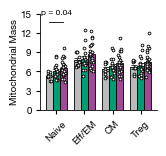

In [21]:
# Load the dataset
df = pd.read_csv('/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure3/manuscript_SCARAB-CD4T_mito-assays.csv')

# Define the groups, color scheme, and cell types
group_order = ['NHC', 'CI-NS', 'CI-Sep']
group_palette = {'NHC': '#BBBBBB', 'CI-NS': '#009E73', 'CI-Sep': '#9F4A96'}

# Define the cell types of interest with readable labels
cell_types = {
    'CD4 T Naïve': 'Naive',
    'CD4 T Eff/EM': 'Eff/EM',
    'CD4 T CM': 'CM',
    'CD4 Treg': 'Treg'
}

# Filter the dataset for the cell types of interest
df = df[df['CellType'].isin(cell_types.keys())]

# Reshape the DataFrame for plotting
df_long = df.melt(id_vars=['Group', 'CellType'], value_vars=['Mass'], 
                  var_name='Metric', value_name='Mitochondrial Mass')
df_long['CellType'] = df_long['CellType'].map(cell_types)

# Calculate means and SEMs for error bars
means_sems = df_long.groupby(['Group', 'CellType'])['Mitochondrial Mass'].agg(['mean', 'sem']).reset_index()

# Set figure size
fig, ax = plt.subplots(figsize=(1.5, 1.25))

# Define bar positions
num_cell_types = len(cell_types)
bar_width = 0.25
x = np.arange(num_cell_types)

# Plot bars for each group, ordered by x-axis labels
for i, cell_type in enumerate(cell_types.values()):
    for j, group in enumerate(group_order):
        # Select the mean and SEM for the current group and cell type
        mean_val = means_sems[(means_sems['Group'] == group) & (means_sems['CellType'] == cell_type)]['mean'].values[0]
        sem_val = means_sems[(means_sems['Group'] == group) & (means_sems['CellType'] == cell_type)]['sem'].values[0]

        # Calculate the bar position
        bar_position = x[i] + j * bar_width - bar_width

        # Plot the bar
        ax.bar(
            bar_position, mean_val, yerr=sem_val, width=bar_width, 
            label=group if i == 0 else "", color=group_palette[group], 
            edgecolor='black', capsize=2, error_kw={'elinewidth': 0.6, 'capthick': 0.6}
        )

        # Overlay individual data points with jitter
        subset = df_long[(df_long['Group'] == group) & (df_long['CellType'] == cell_type)]
        jitter = (np.random.rand(len(subset)) - 0.5) * 0.1  # Jitter for visualization

        # Adjust x-coordinates to match the corresponding bars
        x_coords = [bar_position + jitter_val for jitter_val in jitter]
        ax.scatter(
            x_coords, subset['Mitochondrial Mass'], color='white', edgecolor='black', 
            s=4, linewidth=0.6, zorder=3
        )

# Add a solid horizontal line at y=0
ax.axhline(0, color='black', linewidth=0.6)

# Set x-ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(cell_types.values(), rotation=45, ha='center')

# Set y-axis limits and ticks
ax.set_ylim(0, 15)  # Set y-axis height to range from 0 to 40
ax.set_yticks(np.arange(0, 16, 3))  # Set tick marks every 10
ax.set_ylabel('Mitochondrial Mass', labelpad=1)

# Perform Kruskal-Wallis test and Dunn's post-hoc test for each cell type
for cell_type in cell_types.values():
    subsets = [df_long[(df_long['Group'] == group) & (df_long['CellType'] == cell_type)]['Mitochondrial Mass'] for group in group_order]
    kw_stat, kw_pval = kruskal(*subsets)
    print(f'\n{cell_type} - Kruskal-Wallis H-statistic: {kw_stat:.2f}, p-value: {kw_pval:.4f}')
    
    # Always perform Dunn's post-hoc test
    dunn_results = sp.posthoc_dunn(
        df_long[df_long['CellType'] == cell_type], 
        val_col='Mitochondrial Mass', group_col='Group', p_adjust='bonferroni'
    )
    
    # Display Dunn's test results in table format
    print(f"{cell_type} - Dunn's post-hoc test (Bonferroni-adjusted p-values):\n{dunn_results}\n")
    
    # Add comparison bars and p-values for significant results (K-W p < 0.05 and Dunn's p < 0.25)
    if kw_pval < 0.05:
        offset_increment = 1  # Adjust to prevent overlapping
        current_y_pos = max(df_long['Mitochondrial Mass']) * 1.1  # Start position for comparison lines

        for i, group1 in enumerate(group_order):
            for j, group2 in enumerate(group_order):
                if i < j:  # Only consider each pair once
                    p_val = dunn_results.loc[group1, group2]
                    if p_val < 0.25:
                        # Calculate bar positions for comparison lines
                        x_start = x[list(cell_types.values()).index(cell_type)] + i * bar_width - bar_width
                        x_end = x[list(cell_types.values()).index(cell_type)] + j * bar_width - bar_width
                        y_pos = current_y_pos

                        # Add the comparison line
                        ax.plot([x_start, x_end], [y_pos, y_pos], color='black', linewidth=0.6)
                        
                        # Add p-value text above the bar
                        ax.text((x_start + x_end) / 2, y_pos + 1, f'p = {p_val:.2f}', 
                                ha='center', va='bottom', fontsize=6, color='black')

                        # Update current y-position for the next comparison line
                        current_y_pos += offset_increment

# Show the plot
plt.savefig('Mitochondrial_Mass.svg')
plt.show()


Naive - Kruskal-Wallis H-statistic: 10.22, p-value: 0.0060
Naive - Dunn's post-hoc test (Bonferroni-adjusted p-values):
           CI-NS    CI-Sep       NHC
CI-NS   1.000000  0.223378  0.402869
CI-Sep  0.223378  1.000000  0.005436
NHC     0.402869  0.005436  1.000000


Eff/EM - Kruskal-Wallis H-statistic: 4.05, p-value: 0.1318
Eff/EM - Dunn's post-hoc test (Bonferroni-adjusted p-values):
           CI-NS    CI-Sep  NHC
CI-NS   1.000000  0.134113  1.0
CI-Sep  0.134113  1.000000  1.0
NHC     1.000000  1.000000  1.0


CM - Kruskal-Wallis H-statistic: 3.03, p-value: 0.2200
CM - Dunn's post-hoc test (Bonferroni-adjusted p-values):
           CI-NS    CI-Sep       NHC
CI-NS   1.000000  0.403774  1.000000
CI-Sep  0.403774  1.000000  0.511149
NHC     1.000000  0.511149  1.000000


Treg - Kruskal-Wallis H-statistic: 5.57, p-value: 0.0616
Treg - Dunn's post-hoc test (Bonferroni-adjusted p-values):
           CI-NS    CI-Sep       NHC
CI-NS   1.000000  0.056988  1.000000
CI-Sep  0.056988  1.0000

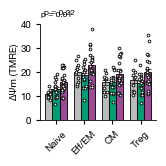

In [23]:
# Load the dataset
df = pd.read_csv('/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure3/manuscript_SCARAB-CD4T_mito-assays.csv')

# Define the groups, color scheme, and cell types
group_order = ['NHC', 'CI-NS', 'CI-Sep']
group_palette = {'NHC': '#BBBBBB', 'CI-NS': '#009E73', 'CI-Sep': '#9F4A96'}

# Define the cell types of interest with readable labels
cell_types = {
    'CD4 T Naïve': 'Naive',
    'CD4 T Eff/EM': 'Eff/EM',
    'CD4 T CM': 'CM',
    'CD4 Treg': 'Treg'
}

# Filter the dataset for the cell types of interest
df = df[df['CellType'].isin(cell_types.keys())]

# Reshape the DataFrame for plotting
df_long = df.melt(id_vars=['Group', 'CellType'], value_vars=['TMRE'], 
                  var_name='Metric', value_name='TMRE')
df_long['CellType'] = df_long['CellType'].map(cell_types)

# Calculate means and SEMs for error bars
means_sems = df_long.groupby(['Group', 'CellType'])['TMRE'].agg(['mean', 'sem']).reset_index()

# Set figure size
fig, ax = plt.subplots(figsize=(1.5, 1.25))

# Define bar positions
num_cell_types = len(cell_types)
bar_width = 0.25
x = np.arange(num_cell_types)

# Plot bars for each group, ordered by x-axis labels
for i, cell_type in enumerate(cell_types.values()):
    for j, group in enumerate(group_order):
        # Select the mean and SEM for the current group and cell type
        mean_val = means_sems[(means_sems['Group'] == group) & (means_sems['CellType'] == cell_type)]['mean'].values[0]
        sem_val = means_sems[(means_sems['Group'] == group) & (means_sems['CellType'] == cell_type)]['sem'].values[0]

        # Calculate the bar position
        bar_position = x[i] + j * bar_width - bar_width

        # Plot the bar
        ax.bar(
            bar_position, mean_val, yerr=sem_val, width=bar_width, 
            label=group if i == 0 else "", color=group_palette[group], 
            edgecolor='black', capsize=2, error_kw={'elinewidth': 0.6, 'capthick': 0.6}
        )

        # Overlay individual data points with jitter
        subset = df_long[(df_long['Group'] == group) & (df_long['CellType'] == cell_type)]
        jitter = (np.random.rand(len(subset)) - 0.5) * 0.1  # Jitter for visualization

        # Adjust x-coordinates to match the corresponding bars
        x_coords = [bar_position + jitter_val for jitter_val in jitter]
        ax.scatter(
            x_coords, subset['TMRE'], color='white', edgecolor='black', 
            s=4, linewidth=0.6, zorder=3
        )

# Add a solid horizontal line at y=0
ax.axhline(0, color='black', linewidth=0.6)

# Set x-ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(cell_types.values(), rotation=45, ha='center')

# Set y-axis limits and ticks
ax.set_ylim(0, 40)  # Adjust y-axis height as needed
ax.set_yticks(np.arange(0, 41, 10))  # Set tick marks every 5
ax.set_ylabel('ΔΨm (TMRE)', labelpad=1)

# Perform Kruskal-Wallis test and Dunn's post-hoc test for each cell type
for cell_type in cell_types.values():
    subsets = [df_long[(df_long['Group'] == group) & (df_long['CellType'] == cell_type)]['TMRE'] for group in group_order]
    kw_stat, kw_pval = kruskal(*subsets)
    print(f'\n{cell_type} - Kruskal-Wallis H-statistic: {kw_stat:.2f}, p-value: {kw_pval:.4f}')
    
    # Always perform Dunn's post-hoc test
    dunn_results = sp.posthoc_dunn(
        df_long[df_long['CellType'] == cell_type], 
        val_col='TMRE', group_col='Group', p_adjust='bonferroni'
    )
    
    # Display Dunn's test results in table format
    print(f"{cell_type} - Dunn's post-hoc test (Bonferroni-adjusted p-values):\n{dunn_results}\n")
    
    # Add comparison bars and p-values for significant results (K-W p < 0.05 and Dunn's p < 0.25)
    if kw_pval < 0.05:
        offset_increment = 1  # Adjust to prevent overlapping
        current_y_pos = max(df_long['TMRE']) * 1.1  # Start position for comparison lines

        for i, group1 in enumerate(group_order):
            for j, group2 in enumerate(group_order):
                if i < j:  # Only consider each pair once
                    p_val = dunn_results.loc[group1, group2]
                    if p_val < 0.25:
                        # Calculate bar positions for comparison lines
                        x_start = x[list(cell_types.values()).index(cell_type)] + i * bar_width - bar_width
                        x_end = x[list(cell_types.values()).index(cell_type)] + j * bar_width - bar_width
                        y_pos = current_y_pos

                        # Add the comparison line
                        ax.plot([x_start, x_end], [y_pos, y_pos], color='black', linewidth=0.6)
                        
                        # Add p-value text above the bar
                        ax.text((x_start + x_end) / 2, y_pos + 1, f'p = {p_val:.2f}', 
                                ha='center', va='bottom', fontsize=6, color='black')

                        # Update current y-position for the next comparison line
                        current_y_pos += offset_increment

# Show the plot
plt.savefig('TMRE.svg')
plt.show()


Naive - Kruskal-Wallis H-statistic: 8.02, p-value: 0.0181
Naive - Dunn's post-hoc test (Bonferroni-adjusted p-values):
           CI-NS    CI-Sep       NHC
CI-NS   1.000000  0.067188  1.000000
CI-Sep  0.067188  1.000000  0.050553
NHC     1.000000  0.050553  1.000000


Eff/EM - Kruskal-Wallis H-statistic: 3.58, p-value: 0.1669
Eff/EM - Dunn's post-hoc test (Bonferroni-adjusted p-values):
           CI-NS    CI-Sep       NHC
CI-NS   1.000000  0.228523  0.467871
CI-Sep  0.228523  1.000000  1.000000
NHC     0.467871  1.000000  1.000000


CM - Kruskal-Wallis H-statistic: 4.27, p-value: 0.1181
CM - Dunn's post-hoc test (Bonferroni-adjusted p-values):
          CI-NS   CI-Sep  NHC
CI-NS   1.00000  0.11679  1.0
CI-Sep  0.11679  1.00000  1.0
NHC     1.00000  1.00000  1.0


Treg - Kruskal-Wallis H-statistic: 6.29, p-value: 0.0431
Treg - Dunn's post-hoc test (Bonferroni-adjusted p-values):
           CI-NS    CI-Sep      NHC
CI-NS   1.000000  0.038984  0.42117
CI-Sep  0.038984  1.000000  1.00000

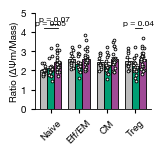

In [24]:
# Load the dataset
df = pd.read_csv('/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure3/manuscript_SCARAB-CD4T_mito-assays.csv')

# Define the groups, color scheme, and cell types
group_order = ['NHC', 'CI-NS', 'CI-Sep']
group_palette = {'NHC': '#BBBBBB', 'CI-NS': '#009E73', 'CI-Sep': '#9F4A96'}

# Define the cell types of interest with readable labels
cell_types = {
    'CD4 T Naïve': 'Naive',
    'CD4 T Eff/EM': 'Eff/EM',
    'CD4 T CM': 'CM',
    'CD4 Treg': 'Treg'
}

# Filter the dataset for the cell types of interest
df = df[df['CellType'].isin(cell_types.keys())]

# Reshape the DataFrame for plotting
df_long = df.melt(id_vars=['Group', 'CellType'], value_vars=['Ratio'], 
                  var_name='Metric', value_name='Ratio')
df_long['CellType'] = df_long['CellType'].map(cell_types)

# Calculate means and SEMs for error bars
means_sems = df_long.groupby(['Group', 'CellType'])['Ratio'].agg(['mean', 'sem']).reset_index()

# Set figure size
fig, ax = plt.subplots(figsize=(1.5, 1.25))

# Define bar positions
num_cell_types = len(cell_types)
bar_width = 0.25
x = np.arange(num_cell_types)

# Plot bars for each group, ordered by x-axis labels
for i, cell_type in enumerate(cell_types.values()):
    for j, group in enumerate(group_order):
        # Select the mean and SEM for the current group and cell type
        mean_val = means_sems[(means_sems['Group'] == group) & (means_sems['CellType'] == cell_type)]['mean'].values[0]
        sem_val = means_sems[(means_sems['Group'] == group) & (means_sems['CellType'] == cell_type)]['sem'].values[0]

        # Calculate the bar position
        bar_position = x[i] + j * bar_width - bar_width

        # Plot the bar
        ax.bar(
            bar_position, mean_val, yerr=sem_val, width=bar_width, 
            label=group if i == 0 else "", color=group_palette[group], 
            edgecolor='black', capsize=2, error_kw={'elinewidth': 0.6, 'capthick': 0.6}
        )

        # Overlay individual data points with jitter
        subset = df_long[(df_long['Group'] == group) & (df_long['CellType'] == cell_type)]
        jitter = (np.random.rand(len(subset)) - 0.5) * 0.1  # Jitter for visualization

        # Adjust x-coordinates to match the corresponding bars
        x_coords = [bar_position + jitter_val for jitter_val in jitter]
        ax.scatter(
            x_coords, subset['Ratio'], color='white', edgecolor='black', 
            s=4, linewidth=0.6, zorder=3
        )

# Add a solid horizontal line at y=0
ax.axhline(0, color='black', linewidth=0.6)

# Set x-ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(cell_types.values(), rotation=45, ha='center')

# Set y-axis limits and ticks
ax.set_ylim(0, 5)  # Adjust y-axis height as needed
ax.set_yticks(np.arange(0, 6, 1))  # Set tick marks every 1
ax.set_ylabel('Ratio (ΔΨm/Mass)', labelpad=1)

# Perform Kruskal-Wallis test and Dunn's post-hoc test for each cell type
for cell_type in cell_types.values():
    subsets = [df_long[(df_long['Group'] == group) & (df_long['CellType'] == cell_type)]['Ratio'] for group in group_order]
    kw_stat, kw_pval = kruskal(*subsets)
    print(f'\n{cell_type} - Kruskal-Wallis H-statistic: {kw_stat:.2f}, p-value: {kw_pval:.4f}')
    
    # Always perform Dunn's post-hoc test
    dunn_results = sp.posthoc_dunn(
        df_long[df_long['CellType'] == cell_type], 
        val_col='Ratio', group_col='Group', p_adjust='bonferroni'
    )
    
    # Display Dunn's test results in table format
    print(f"{cell_type} - Dunn's post-hoc test (Bonferroni-adjusted p-values):\n{dunn_results}\n")
    
    # Add comparison bars and p-values for significant results (K-W p < 0.05 and Dunn's p < 0.25)
    if kw_pval < 0.05:
        offset_increment = 0.2  # Adjust to prevent overlapping
        current_y_pos = max(df_long['Ratio']) * 1.1  # Start position for comparison lines

        for i, group1 in enumerate(group_order):
            for j, group2 in enumerate(group_order):
                if i < j:  # Only consider each pair once
                    p_val = dunn_results.loc[group1, group2]
                    if p_val < 0.25:
                        # Calculate bar positions for comparison lines
                        x_start = x[list(cell_types.values()).index(cell_type)] + i * bar_width - bar_width
                        x_end = x[list(cell_types.values()).index(cell_type)] + j * bar_width - bar_width
                        y_pos = current_y_pos

                        # Add the comparison line
                        ax.plot([x_start, x_end], [y_pos, y_pos], color='black', linewidth=0.6)
                        
                        # Add p-value text above the bar
                        ax.text((x_start + x_end) / 2, y_pos + 0.1, f'p = {p_val:.2f}', 
                                ha='center', va='bottom', fontsize=6, color='black')

                        # Update current y-position for the next comparison line
                        current_y_pos += offset_increment

# Show the plot
plt.savefig('MM_MMP_Ratio.svg')
plt.show()

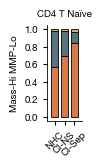

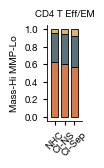

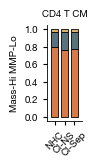

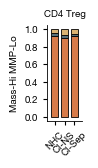

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure3/manuscript_SCARAB-CD4T_mito-assays.csv')

# Define the groups and color scheme
group_order = ['NHC', 'CI-NS', 'CI-Sep']
group_palette = {'prop_Hi-Hi': '#D77B4A', 'prop_Lo-Lo': '#5A727C', 'prop_Hi-Lo': '#DAB373'}
cell_types = ['CD4 T Naïve', 'CD4 T Eff/EM', 'CD4 T CM', 'CD4 Treg']

def plot_stacked_bar_proportions(df, cell_types):
    """
    Function to plot stacked bar proportions for specified cell types.

    Parameters:
    df (DataFrame): Data containing the proportions and cell types.
    cell_types (list): List of cell types to plot.
    """
    for cell_type in cell_types:
        # Filter data for the current cell type and make an explicit copy to avoid SettingWithCopyWarning
        cell_data = df.loc[df['CellType'] == cell_type].copy()

        # Convert proportion columns to numeric
        cell_data.loc[:, ['prop_Hi-Hi', 'prop_Hi-Lo', 'prop_Lo-Lo']] = cell_data[['prop_Hi-Hi', 'prop_Hi-Lo', 'prop_Lo-Lo']].apply(pd.to_numeric, errors='coerce')

        # Calculate mean proportions for each group
        mean_props = cell_data.groupby('Group')[['prop_Hi-Hi', 'prop_Hi-Lo', 'prop_Lo-Lo']].mean()

        # Set figure size
        fig, ax = plt.subplots(figsize=(0.45, 1.25))

        # Define bar positions and width
        x = np.arange(len(group_order))
        bar_width = 0.75

        # Initialize the bottom for stacking
        bottom = np.zeros(len(group_order))

        # Order of stacking: Hi-Hi (bottom), Lo-Lo (middle), Hi-Lo (top)
        stack_order = ['prop_Hi-Hi', 'prop_Lo-Lo', 'prop_Hi-Lo']
        for prop in stack_order:
            ax.bar(
                x, mean_props.loc[group_order][prop], width=bar_width, label=prop, color=group_palette[prop],
                bottom=bottom, edgecolor='black'
            )
            bottom += mean_props.loc[group_order][prop]

        # Formatting
        ax.set_xticks(x)
        ax.set_xticklabels(group_order, rotation=45, ha='center')
        ax.set_ylabel('Mass-Hi MMP-Lo')
        ax.set_title(cell_type)
        
        # Add padding on the left and right edges
        ax.set_xlim(-0.75, len(group_order) - 0.25)  # Slight padding added

        # Set y-axis limits
        ax.set_ylim(-0.05, 1.05)  # Add a small gap at the top and bottom
        ax.set_yticks(np.arange(0, 1.1, 0.2))

        # Replace slashes in cell type names to avoid issues in the file name
        safe_cell_type = cell_type.replace('/', '_')
        
        # Save the plot as an SVG
        plt.savefig(f'{safe_cell_type}_Proportion_Stacked_Bar.svg')
        
        # Show each plot
        plt.show()

# Call the function to plot all specified cell types
plot_stacked_bar_proportions(df, cell_types)


Naive - Kruskal-Wallis H-statistic: 4.30, p-value: 0.1165
Naive - Dunn's post-hoc test (Bonferroni-adjusted p-values):
           CI-NS    CI-Sep       NHC
CI-NS   1.000000  1.000000  0.431743
CI-Sep  1.000000  1.000000  0.115994
NHC     0.431743  0.115994  1.000000


Eff/EM - Kruskal-Wallis H-statistic: 6.55, p-value: 0.0379
Eff/EM - Dunn's post-hoc test (Bonferroni-adjusted p-values):
           CI-NS    CI-Sep       NHC
CI-NS   1.000000  0.752554  0.421515
CI-Sep  0.752554  1.000000  0.032584
NHC     0.421515  0.032584  1.000000


CM - Kruskal-Wallis H-statistic: 2.89, p-value: 0.2360
CM - Dunn's post-hoc test (Bonferroni-adjusted p-values):
           CI-NS    CI-Sep       NHC
CI-NS   1.000000  0.381722  1.000000
CI-Sep  0.381722  1.000000  0.631974
NHC     1.000000  0.631974  1.000000


Treg - Kruskal-Wallis H-statistic: 1.01, p-value: 0.6037
Treg - Dunn's post-hoc test (Bonferroni-adjusted p-values):
           CI-NS  CI-Sep       NHC
CI-NS   1.000000     1.0  0.995001
CI-Sep  1

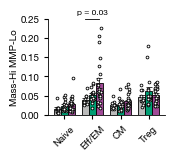

In [59]:
# Load the dataset
df = pd.read_csv('/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure3/manuscript_SCARAB-CD4T_mito-assays.csv')

# Define the groups, color scheme, and cell types
group_order = ['NHC', 'CI-NS', 'CI-Sep']
group_palette = {'NHC': '#BBBBBB', 'CI-NS': '#009E73', 'CI-Sep': '#9F4A96'}

# Define the cell types of interest with readable labels
cell_types = {
    'CD4 T Naïve': 'Naive',
    'CD4 T Eff/EM': 'Eff/EM',
    'CD4 T CM': 'CM',
    'CD4 Treg': 'Treg'
}

# Filter the dataset for the cell types of interest
df = df[df['CellType'].isin(cell_types.keys())]

# Reshape the DataFrame for plotting
df_long = df.melt(id_vars=['Group', 'CellType'], value_vars=['prop_Hi-Lo'], 
                  var_name='Metric', value_name='prop_Hi-Lo')
df_long['CellType'] = df_long['CellType'].map(cell_types)

# Ensure 'prop_Hi-Lo' column is numeric to avoid issues in calculations
df_long['prop_Hi-Lo'] = pd.to_numeric(df_long['prop_Hi-Lo'], errors='coerce')

# Calculate means and SEMs for error bars
means_sems = df_long.groupby(['Group', 'CellType'])['prop_Hi-Lo'].agg(['mean', 'sem']).reset_index()

# Set figure size
fig, ax = plt.subplots(figsize=(1.5, 1.25))

# Define bar positions
num_cell_types = len(cell_types)
bar_width = 0.25
x = np.arange(num_cell_types)

# Plot bars for each group, ordered by x-axis labels
for i, cell_type in enumerate(cell_types.values()):
    for j, group in enumerate(group_order):
        # Select the mean and SEM for the current group and cell type
        mean_val = means_sems[(means_sems['Group'] == group) & (means_sems['CellType'] == cell_type)]['mean'].values[0]
        sem_val = means_sems[(means_sems['Group'] == group) & (means_sems['CellType'] == cell_type)]['sem'].values[0]

        # Calculate the bar position
        bar_position = x[i] + j * bar_width - bar_width

        # Plot the bar
        ax.bar(
            bar_position, mean_val, yerr=sem_val, width=bar_width, 
            label=group if i == 0 else "", color=group_palette[group], 
            edgecolor='black', capsize=2, error_kw={'elinewidth': 0.6, 'capthick': 0.6}
        )

        # Overlay individual data points with jitter
        subset = df_long[(df_long['Group'] == group) & (df_long['CellType'] == cell_type)]
        jitter = (np.random.rand(len(subset)) - 0.5) * 0.1  # Jitter for visualization

        # Adjust x-coordinates to match the corresponding bars
        x_coords = [bar_position + jitter_val for jitter_val in jitter]
        ax.scatter(
            x_coords, subset['prop_Hi-Lo'], color='white', edgecolor='black', 
            s=4, linewidth=0.6, zorder=3
        )

# Add a solid horizontal line at y=0
ax.axhline(0, color='black', linewidth=0.6)

# Set x-ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(cell_types.values(), rotation=45, ha='center')

# Set y-axis limits and ticks
ax.set_ylim(0, 0.25)  # Adjust y-axis height as needed
ax.set_yticks(np.arange(0, 0.26, 0.05))  # Set tick marks every 0.2
ax.set_ylabel('Mass-Hi MMP-Lo', labelpad=1)

# Perform Kruskal-Wallis test and Dunn's post-hoc test for each cell type
for cell_type in cell_types.values():
    subsets = [df_long[(df_long['Group'] == group) & (df_long['CellType'] == cell_type)]['prop_Hi-Lo'] for group in group_order]
    kw_stat, kw_pval = kruskal(*subsets)
    print(f'\n{cell_type} - Kruskal-Wallis H-statistic: {kw_stat:.2f}, p-value: {kw_pval:.4f}')
    
    # Always perform Dunn's post-hoc test
    dunn_results = sp.posthoc_dunn(
        df_long[df_long['CellType'] == cell_type], 
        val_col='prop_Hi-Lo', group_col='Group', p_adjust='bonferroni'
    )
    
    # Display Dunn's test results in table format
    print(f"{cell_type} - Dunn's post-hoc test (Bonferroni-adjusted p-values):\n{dunn_results}\n")
    
    # Add comparison bars and p-values for significant results (K-W p < 0.05 and Dunn's p < 0.25)
    if kw_pval < 0.05:
        offset_increment = 0.02  # Adjust to prevent overlapping
        current_y_pos = max(df_long['prop_Hi-Lo']) * 1.1  # Start position for comparison lines

        for i, group1 in enumerate(group_order):
            for j, group2 in enumerate(group_order):
                if i < j:  # Only consider each pair once
                    p_val = dunn_results.loc[group1, group2]
                    if p_val < 0.25:
                        # Calculate bar positions for comparison lines
                        x_start = x[list(cell_types.values()).index(cell_type)] + i * bar_width - bar_width
                        x_end = x[list(cell_types.values()).index(cell_type)] + j * bar_width - bar_width
                        y_pos = current_y_pos

                        # Add the comparison line
                        ax.plot([x_start, x_end], [y_pos, y_pos], color='black', linewidth=0.6)
                        
                        # Add p-value text above the bar
                        ax.text((x_start + x_end) / 2, y_pos + 0.01, f'p = {p_val:.2f}', 
                                ha='center', va='bottom', fontsize=6, color='black')

                        # Update current y-position for the next comparison line
                        current_y_pos += offset_increment

# Save and show the plot
plt.savefig('prop_Hi-Lo_Proportion.svg')
plt.show()


Naive - Kruskal-Wallis H-statistic: 9.59, p-value: 0.0083
Naive - Dunn's post-hoc test (Bonferroni-adjusted p-values):
           CI-NS    CI-Sep    Ci-Sep       NHC
CI-NS   1.000000  0.062013  0.901970  1.000000
CI-Sep  0.062013  1.000000  1.000000  0.049545
Ci-Sep  0.901970  1.000000  1.000000  0.639148
NHC     1.000000  0.049545  0.639148  1.000000


Eff/EM - Kruskal-Wallis H-statistic: 5.59, p-value: 0.0611
Eff/EM - Dunn's post-hoc test (Bonferroni-adjusted p-values):
           CI-NS    CI-Sep  Ci-Sep       NHC
CI-NS   1.000000  0.187164     1.0  1.000000
CI-Sep  0.187164  1.000000     1.0  0.372516
Ci-Sep  1.000000  1.000000     1.0  1.000000
NHC     1.000000  0.372516     1.0  1.000000


CM - Kruskal-Wallis H-statistic: 8.25, p-value: 0.0162
CM - Dunn's post-hoc test (Bonferroni-adjusted p-values):
           CI-NS    CI-Sep    Ci-Sep       NHC
CI-NS   1.000000  0.082197  1.000000  1.000000
CI-Sep  0.082197  1.000000  1.000000  0.103090
Ci-Sep  1.000000  1.000000  1.000000  0.9

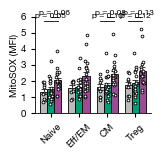

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kruskal
import scikit_posthocs as sp

# Load the dataset
df = pd.read_csv('/home/mstier/Documents/Manuscript_2024_Sepsis-CD4T-KYN/Figure3/2024-02-06_flow_MitoSOX-gMFI_POOLED.csv')

# Define the groups, color scheme, and cell types
group_order = ['NHC', 'CI-NS', 'CI-Sep']
group_palette = {'NHC': '#BBBBBB', 'CI-NS': '#009E73', 'CI-Sep': '#9F4A96'}
cell_types = {
    'CD4 Tnaive': 'Naive',
    'CD4 Teffem': 'Eff/EM',
    'CD4 Tcm': 'CM',
    'CD4 Treg': 'Treg'
}

# Filter the dataset for the cell types of interest
df = df[['Group'] + list(cell_types.keys())]

# Reshape the DataFrame for plotting
df_long = df.melt(id_vars=['Group'], value_vars=cell_types.keys(), 
                  var_name='CellType', value_name='MitoSOX')
df_long['CellType'] = df_long['CellType'].map(cell_types)

# Convert 'MitoSOX' column to numeric to avoid type issues
df_long['MitoSOX'] = pd.to_numeric(df_long['MitoSOX'], errors='coerce')

# Calculate means and SEMs for error bars
means_sems = df_long.groupby(['Group', 'CellType'])['MitoSOX'].agg(['mean', 'sem']).reset_index()

# Set figure size
fig, ax = plt.subplots(figsize=(1.5, 1.25))

# Define bar positions
num_cell_types = len(cell_types)
bar_width = 0.25
x = np.arange(num_cell_types)

# Plot bars for each group, ordered by x-axis labels
for i, cell_type in enumerate(cell_types.values()):
    for j, group in enumerate(group_order):
        # Select the mean and SEM for the current group and cell type
        mean_val = means_sems[(means_sems['Group'] == group) & (means_sems['CellType'] == cell_type)]['mean'].values[0]
        sem_val = means_sems[(means_sems['Group'] == group) & (means_sems['CellType'] == cell_type)]['sem'].values[0]

        # Calculate the bar position
        bar_position = x[i] + j * bar_width - bar_width

        # Plot the bar
        ax.bar(
            bar_position, mean_val, yerr=sem_val, width=bar_width, 
            label=group if i == 0 else "", color=group_palette[group], 
            edgecolor='black', capsize=2, error_kw={'elinewidth': 0.6, 'capthick': 0.6}
        )

        # Overlay individual data points with jitter
        subset = df_long[(df_long['Group'] == group) & (df_long['CellType'] == cell_type)]
        jitter = (np.random.rand(len(subset)) - 0.5) * 0.1  # Jitter for visualization

        # Adjust x-coordinates to match the corresponding bars
        x_coords = [bar_position + jitter_val for jitter_val in jitter]
        ax.scatter(
            x_coords, subset['MitoSOX'], color='white', edgecolor='black', 
            s=4, linewidth=0.6, zorder=3
        )

# Add a solid horizontal line at y=0
ax.axhline(0, color='black', linewidth=0.6)

# Set x-ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(cell_types.values(), rotation=45, ha='center')

# Set y-axis limits and ticks
ax.set_ylim(0, 6)  # Adjust y-axis height as needed
ax.set_yticks(np.arange(0, 7, 1))  # Set tick marks every 1
ax.set_ylabel('MitoSOX (MFI)', labelpad=1)

# Perform Kruskal-Wallis test and Dunn's post-hoc test for each cell type
for cell_type in cell_types.values():
    subsets = [df_long[(df_long['Group'] == group) & (df_long['CellType'] == cell_type)]['MitoSOX'] for group in group_order]
    kw_stat, kw_pval = kruskal(*subsets)
    print(f'\n{cell_type} - Kruskal-Wallis H-statistic: {kw_stat:.2f}, p-value: {kw_pval:.4f}')
    
    # Always perform Dunn's post-hoc test
    dunn_results = sp.posthoc_dunn(
        df_long[df_long['CellType'] == cell_type], 
        val_col='MitoSOX', group_col='Group', p_adjust='bonferroni'
    )
    
    # Display Dunn's test results in table format
    print(f"{cell_type} - Dunn's post-hoc test (Bonferroni-adjusted p-values):\n{dunn_results}\n")
    
    # Add comparison bars and p-values for significant results (K-W p < 0.05 and Dunn's p < 0.25)
    if kw_pval < 0.05:
        offset_increment = 0.2  # Adjust to prevent overlapping
        current_y_pos = max(df_long['MitoSOX']) * 1.1  # Start position for comparison lines

        for i, group1 in enumerate(group_order):
            for j, group2 in enumerate(group_order):
                if i < j:  # Only consider each pair once
                    p_val = dunn_results.loc[group1, group2]
                    if p_val < 0.25:
                        # Calculate bar positions for comparison lines
                        x_start = x[list(cell_types.values()).index(cell_type)] + i * bar_width - bar_width
                        x_end = x[list(cell_types.values()).index(cell_type)] + j * bar_width - bar_width
                        y_pos = current_y_pos

                        # Add the comparison line
                        ax.plot([x_start, x_end], [y_pos, y_pos], color='black', linewidth=0.6)
                        
                        # Add p-value text above the bar
                        ax.text((x_start + x_end) / 2, y_pos + 0.1, f'p = {p_val:.2f}', 
                                ha='center', va='bottom', fontsize=6, color='black')

                        # Update current y-position for the next comparison line
                        current_y_pos += offset_increment

# Save and show the plot
plt.savefig('MitoSOX_gMFI.svg')
plt.show()